# Experiment 1 - Visualization of Gene-Expression Clusters in PBMC scRNAseq Data

This experiment creates a variety of visualizations to determine the influence of target genetic markers in development of the tumor genome, and provides an extensive analysis of these visualizations to determine transitions between states. The dataset consists of 4k PBMCs (Human) provided by 10X Genomics. The data is an mtx directory with an `mtx` file (*i.e.* count matrix), two `tsv` files with barcodes (*i.e.* cell indices) and features (*i.e.* gene symbols). `Scanpy` unpacks the files (if the files are in `gz` archive format) and creates an `anndata` object with the `read_10x_mtx` function.    

All code & text produced under private license by Computational Health Informatics Program & Harvard Medical School.
Contributors: Aniket Dey, Felix Dietlein

---



In [ ]:
import scanpy as sc
import anndata as ann
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors

import os
#doublet detection
import scrublet as scr
#batch correction (not installed by default in the docker container, install via command line: pip install scanorama bbknn)
import scanorama as scan
#external modules
import scanpy.external as sce
#pretty plotting
import seaborn as sb

#R interface
import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri


In [ ]:
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
scanpy==1.4.6 anndata==0.7.1 umap==0.4.0 numpy==1.18.2 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


In [ ]:
sb.set_context(context='poster')


In [ ]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
#.libPaths(.libPaths()[c(3,2,1)])

# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
library(DropletUtils)


## Set project file paths

In [ ]:
file_path = '/root/host_home/Documents/ICB/Teaching/2007_scanpy_HMGU/' #this is my file path please adapt it to your directory

In [ ]:
file_path_raw = file_path + '3k_PBMC/'

In [ ]:
data_dir = file_path + 'day1_beginner/data/'

In [ ]:
table_dir = file_path + 'day1_beginner/tables/'

In [ ]:
sc.settings.figdir = file_path + 'day1_beginner/figures/'

# Read data

In [ ]:
file_path_raw = file_path_raw + 'raw_gene_bc_matrices/'


In [ ]:
adata_raw = sc.read_10x_mtx(path=file_path_raw)

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


Let us check the dataset size.

In [ ]:
adata_raw.shape

(737280, 33694)

In [ ]:
print('Total number of observations: {:d}'.format(adata_raw.n_obs))

Total number of observations: 737280


# Pre-processing and visualization

## Remove empty droplets

Prepare input for EmptyDrops.

In [ ]:
sparse_mat = adata_raw.X.T
genes = adata_raw.var_names
barcodes = adata_raw.obs_names

Run EmptyDrops.

In [ ]:
%%R -i sparse_mat -i genes -i barcodes -o barcodes_filtered -o ambient_genes

sce <- SingleCellExperiment(assays = list(counts = sparse_mat), colData=barcodes)
rownames(sce) <- genes
ambient <- emptyDrops(counts(sce))
is_cell <- ambient$FDR <= 0.05
threshold_ambient <- 0.005
ambient_genes <- names(ambient@metadata$ambient[ambient@metadata$ambient> threshold_ambient,])
barcodes_filtered <- barcodes[which(is_cell)]

Empty drops returns a list of potentially ambient genes and the barcodes, which belong to actual cells.

In [ ]:
ambient_genes

array(['RPL11', 'RPS27', 'RPS27A', 'TMSB10', 'RPL32', 'RPL34', 'RPS3A',
       'RPS14', 'HLA-B', 'RPS18', 'EEF1A1', 'RPS12', 'ACTB', 'TMSB4X',
       'RPL10', 'RPL7', 'RPS6', 'RPLP2', 'FTH1', 'MALAT1', 'RPS3',
       'RPL41', 'RPL21', 'RPS29', 'B2M', 'RPLP1', 'RPS2', 'RPS15A',
       'RPL13', 'RPL19', 'RPL18A', 'RPS19', 'FTL', 'RPL13A', 'RPL3',
       'MT-CO1', 'MT-CO3'], dtype='<U6')

In [ ]:
barcodes_filtered

array(['AAACCTGAGAAGGCCT-1', 'AAACCTGAGACAGACC-1', 'AAACCTGAGATAGTCA-1',
       ..., 'TTTGTCACAGGTCCAC-1', 'TTTGTCAGTTAAGACA-1',
       'TTTGTCATCCCAAGAT-1'], dtype='<U18')

Let us create a filtered data matrix using the filtered barcodes.

In [ ]:
adata = adata_raw[np.in1d(adata_raw.obs_names, barcodes_filtered)].copy()

In [ ]:
adata

AnnData object with n_obs × n_vars = 4470 × 33694 
    var: 'gene_ids'

**BONUS**: Examine the level of background gene expression.

Save the filtered data set to file.

In [ ]:
adata.write(data_dir + 'data_filtered.h5ad')

## Quality control

In [ ]:
#adata = sc.read(data_dir + 'data_filtered.h5ad')

Data quality control can be split into cell QC and gene QC. Typical quality measures for assessing the quality of a cell include the number of molecule counts (UMIs), the number of expressed genes, and the fraction of counts that are mitochondrial. A high fraction of mitochondrial reads being picked up can indicate cell stress, as there is a low proportion of nuclear mRNA in the cell. It should be noted that high mitochondrial RNA fractions can also be biological signals indicating elevated respiration.

We start with calculating the QC covariates:

* total number of counts per cell
* number of expressed genes per cell
* fraction of mitochondrial reads per cell

Note: mitochondrial genes in human start with 'MT-'

In [ ]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(axis = 1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(axis = 1)

mt_gene_mask = np.flatnonzero([gene.startswith('MT-') for gene in adata.var_names])
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['mt_frac'] = np.sum(adata[:, mt_gene_mask].X, axis=1).A1/adata.obs['n_counts']

Let us visualize the number of expressed genes and the number of counts as a scatter plot.

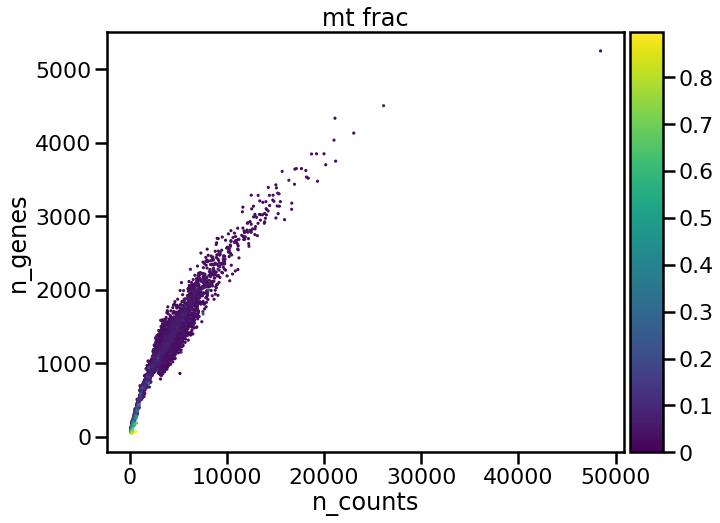

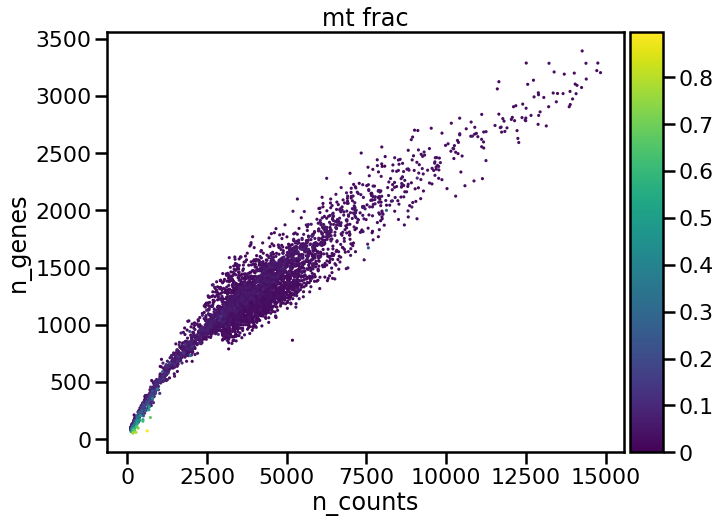

In [ ]:
#Data quality summary plots
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', color='mt_frac', size=40)
p2 = sc.pl.scatter(adata[adata.obs['n_counts']<15000], 'n_counts', 'n_genes',
                   color='mt_frac', size=40)

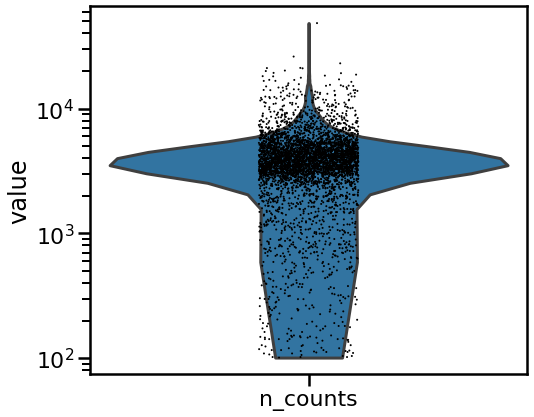

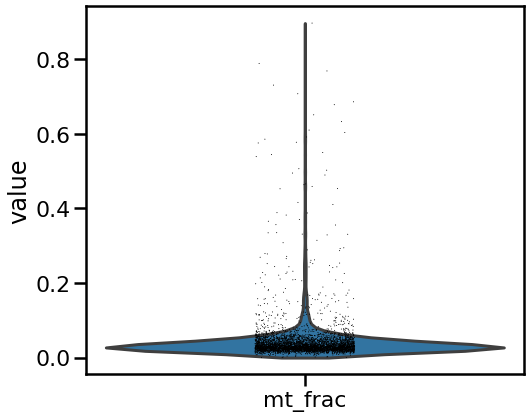

In [ ]:
#Sample quality plots
rcParams['figure.figsize']=(7,7)
t1 = sc.pl.violin(adata, 'n_counts',
                  #groupby='sample',
                  size=2, log=True, cut=0)
t2 = sc.pl.violin(adata, 'mt_frac')

In the main cloud of data points,  cells with lower counts and genes tend to have a higher fraction of mitochondrial counts. These cells are likely under stress or are dying. When apoptotic cells are sequenced, there is less mRNA to be captured in the nucleus, and therefore fewer counts overall, and thus a higher fraction of counts fall upon mitochondrial RNA. If cells with high mitochondrial activity were found at higher counts/genes per cell, this would indicate biologically relevant mitochondrial activity.

Create a histogram for the total number of counts. Further, create a histogram for the low count and high count regime, each.

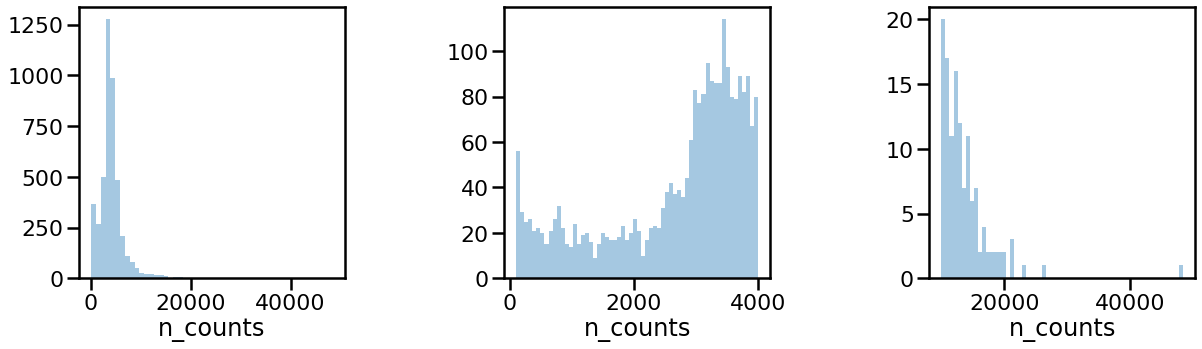

In [ ]:
#Thresholding decision: counts
rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 134)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p3 = sb.distplot(adata.obs['n_counts'],
                 kde=False,
                 ax=fig.add_subplot(fig_ind[0]))
p4 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']<4000],
                 kde=False, bins=60,
                 ax=fig.add_subplot(fig_ind[1]))
p5 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']>10000],
                 kde=False, bins=60,
                 ax=fig.add_subplot(fig_ind[2]))
plt.show()

Histograms of the number of counts per cell show a small peak of groups of cells with fewer than 1000 counts, which are likely uninformative given the overall distribution of counts. This may be cellular debris found in droplets.

On the upper end of counts, we see a population of cells with high counts with decaying slope at 15,000 counts. We estimate this population to range until 20,000 counts. This estimation is performed by visually tracing a Gaussian around the population.

Create a histogram for the total number of genes. Further, create a histogram for the low gene count and high gene count regime, each.

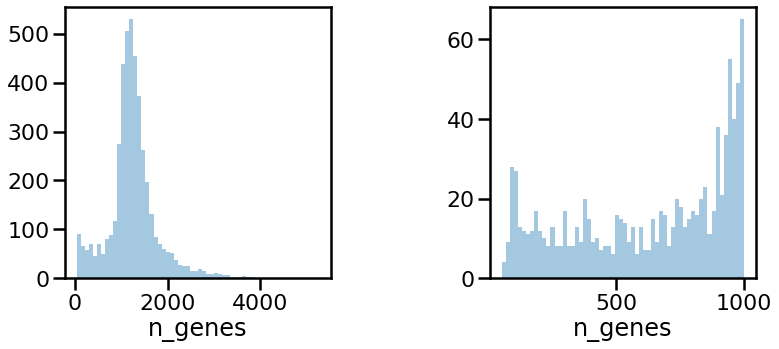

In [ ]:
#Thresholding decision: genes

rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 133)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6) #create a grid for subplots

p6 = sb.distplot(adata.obs['n_genes'], kde=False, bins=60, ax=fig.add_subplot(fig_ind[0]))

p7 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']<1000],
                 kde=False, bins=60, ax=fig.add_subplot(fig_ind[1]))
plt.show()

Two populations of cells with low gene counts can be seen in the above plots. Given these plots, and the plot of genes vs counts above, we decide to filter out cells with fewer than 700 genes expressed. Below this we are likely to find dying cells or empty droplets with ambient RNA. Looking above at the joint plots, we see that we filter out the main density of low gene cells with this threshold.

In general it is a good idea to be permissive in the early filtering steps, and then come back to filter out more stringently when a clear picture is available of what would be filtered out. This is available after visualization/clustering. For demonstration purposes we stick to a simple (and slightly more stringent) filtering here.

Create a histogram for the fraction of mitochondrial genes. Further, create a histogram for the high fraction regime, each.

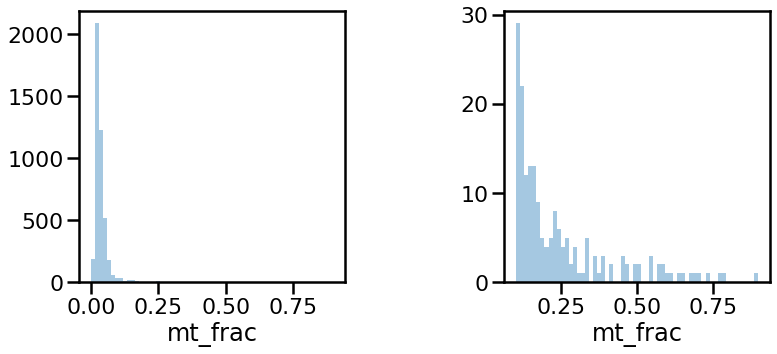

In [ ]:
#Thresholding decision: mitochondrial reads

rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 133)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p8 = sb.distplot(adata.obs['mt_frac'], kde=False, bins=60, ax=fig.add_subplot(fig_ind[0]))

p9 = sb.distplot(adata.obs['mt_frac'][adata.obs['mt_frac']>0.1],
                 kde=False, bins=60, ax=fig.add_subplot(fig_ind[1]))
plt.show()

Filter your cells according for the total number of counts, number of expressed genes and fraction of mitochondrial reads. Check the number of remaining cells after each filtering step.

In [ ]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 1000)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 20000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['mt_frac'] < 0.2]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 700)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

Total number of cells: 4470
filtered out 340 cells that have less than 1000 counts
Number of cells after min count filter: 4130
filtered out 7 cells that have more than 20000 counts
Number of cells after max count filter: 4123
Number of cells after MT filter: 4119
filtered out 146 cells that have less than 700 genes expressed


Trying to set attribute `.obs` of view, copying.


Number of cells after gene filter: 3973


Next, filter out non-expressed genes. Check the number of remaining genes after filtering.

In [ ]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 33694
filtered out 21473 genes that are detected in less than 20 cells
Number of genes after cell filter: 12221


The filtering is performed based on the thresholds we identified from the QC plots. Genes are also filtered if they are not detected in at least 20 cells. This reduces the dimensions of the matrix by removing 0 count genes and genes which are not sufficiently informative of the dataset.

### Doublet score

Let us estimate the amount of doublets in the dataset.

In [ ]:
adata.obs['doublet_score']= np.zeros(adata.shape[0])
adata.obs['doublet'] = np.zeros(adata.shape[0])

In [ ]:
# filtering/preprocessing parameters:
min_counts = 2
min_cells = 3
vscore_percentile = 85
n_pc = 50

# doublet detector parameters:
expected_doublet_rate = 0.02
sim_doublet_ratio = 3
n_neighbors = 15



scrub = scr.Scrublet(counts_matrix = adata.X,
                     n_neighbors = n_neighbors,
                     sim_doublet_ratio = sim_doublet_ratio,
                     expected_doublet_rate = expected_doublet_rate)

doublet_scores, predicted_doublets = scrub.scrub_doublets(
                    min_counts = min_counts,
                    min_cells = min_cells,
                    n_prin_comps = n_pc,
                    use_approx_neighbors = True,
                    get_doublet_neighbor_parents = False)

adata.obs['doublet_score'] = doublet_scores
adata.obs['doublet'] = predicted_doublets


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.10
Detected doublet rate = 3.3%
Estimated detectable doublet fraction = 61.3%
Overall doublet rate:
	Expected   = 2.0%
	Estimated  = 5.3%
Elapsed time: 32.9 seconds


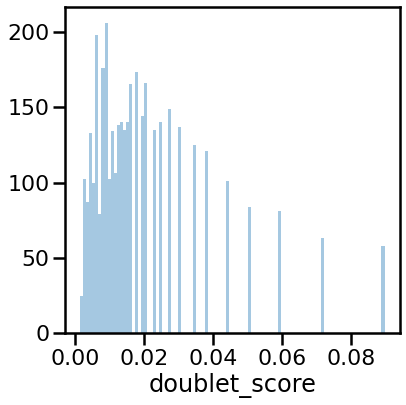

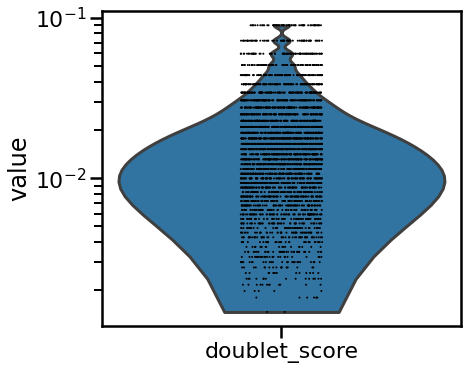

In [ ]:
rcParams['figure.figsize']=(6,6)
sb.distplot(adata.obs['doublet_score'], bins=100, kde=False)
plt.show()


sc.pl.violin(adata, 'doublet_score',
                  size=2, log=True, cut=0)

### filtering doublets

Scrublet proposed a different threshold than we would choose based upon the histogram plot of the doublet scores.

In [ ]:
thr = 0.05
ix_filt = adata.obs['doublet_score']<=thr

adata = adata[ix_filt].copy()
print('Number of cells after doublet filter: {:d}'.format(adata.n_obs))

Number of cells after doublet filter: 3843


### Summarize sample information

In order to group by `batch` (for future purposes, because we presently deal with one sample), let us add a `batch` covariate to the `adata` object.

In [ ]:
adata.obs['batch'] = '1'

df = adata.obs[['n_genes','n_counts', 'batch']]
df_all = pd.DataFrame(df.groupby(by='batch')['n_genes'].apply(np.mean).values,
                      index=df.groupby(by='batch')['n_genes'].apply(np.mean).index,
                      columns=['mean_genes'])

df_all['median_genes']=df.groupby(by='batch')['n_genes'].apply(np.median).values
df_all['mean_counts']=df.groupby(by='batch')['n_counts'].apply(np.mean).values
df_all['median_counts']=df.groupby(by='batch')['n_counts'].apply(np.median).values
df_all

,mean_genes,median_genes,mean_counts,median_counts
batch,,,,
1,1344.74369,1255.0,4406.966309,3976.0


In [ ]:
df_all.to_csv(table_dir + 'data_overview.csv')

## Normalization

So far, our dataset is a count matrix. Here, every count corresponds to an mRNA molecule captured in the scRNA-seq experiment. As not all mRNA molecules in a cell are captured, there is a variability in the total number of counts detected between cells that results from both the number of molecules that were in the cells, and the sampling. As we cannot assume that all cells contain an equal number of molecules (cell sizes can differ substantially), we have to estimate the number of molecules that were initially in the cells. In fact, we don't estimate the exact number of molecules, but instead estimate cell-specific factors that should be proportional to the true number of molecules. These are called size factors. Normalized expression values are calculated by dividing the measured counts by the size factor for the cell.

Several methods for normalization for scRNA-seq data have been proposed. Here, we the `scran` library size normalization followed by log-transformation. In addition, we save the count matrix to `layers` as 'counts'.

In [ ]:
adata.layers['counts'] = adata.X.copy()

In [ ]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added='groups', resolution=0.5)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA with n_comps = 15
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:05)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 10 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:00)


In [ ]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

In [ ]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

... storing 'batch' as categorical


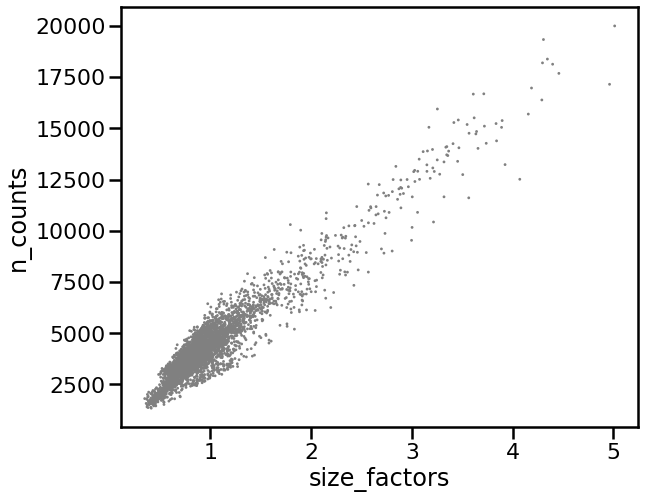

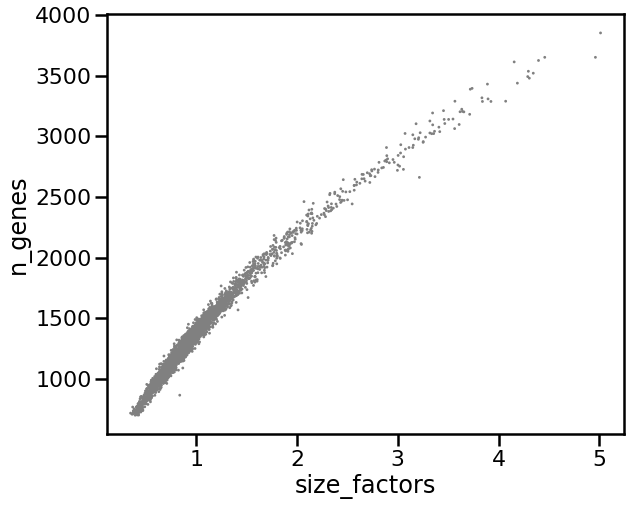

... storing 'batch' as categorical


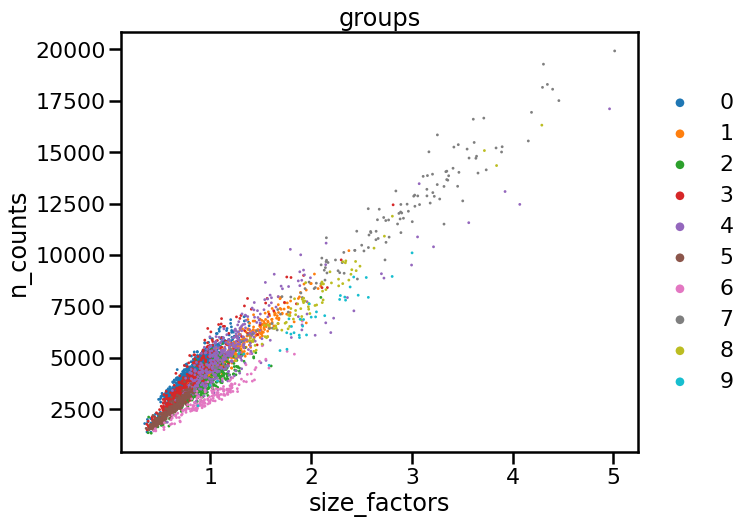

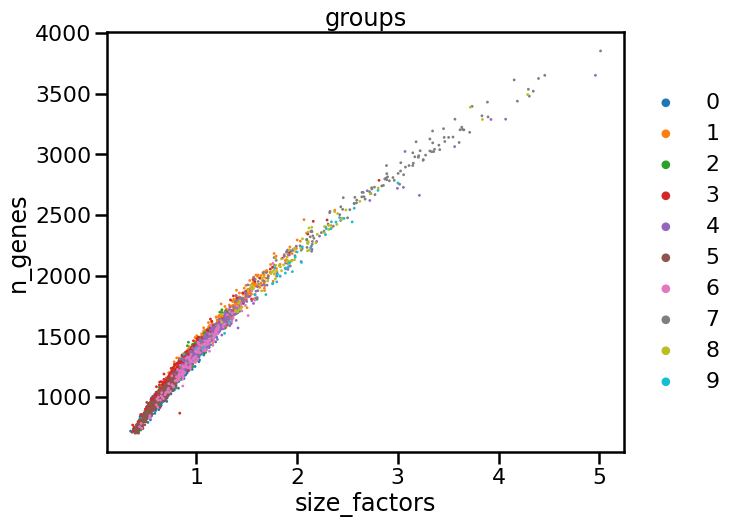

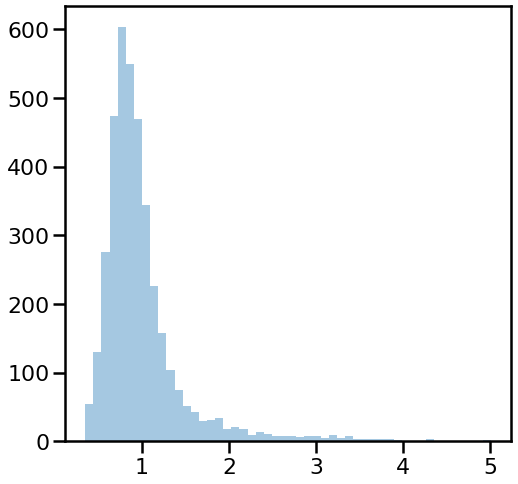

In [ ]:
# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors
adata_pp.obs['size_factors'] = size_factors

rcParams['figure.figsize']=(8,8)
sc.pl.scatter(adata, 'size_factors', 'n_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes')

sc.pl.scatter(adata_pp, 'size_factors', 'n_counts', color='groups')
sc.pl.scatter(adata_pp, 'size_factors', 'n_genes', color='groups')

sb.distplot(size_factors, bins=50, kde=False)
plt.show()

Normalize with scran size-factors and log-scale.

In [ ]:
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)

Modify the format of the resulting data matrix.

In [ ]:
adata.X = np.asarray(adata.X)

Free memory.

In [ ]:
del adata_pp

This dataset consists of a single batch, thus, batch effect correction is not an issue here. If you handle several batches, you may observe differences across samples, for instance, in the library size per dataset. Such differences may contribute to the batch effect. [Büttner et al., Nat Meth (2019)](https://www.nature.com/articles/s41592-018-0254-1) compared the performance of several batch correction methods. For low-to-medium complexity datasets, ComBat performed best among the tested tools. ComBat is also available in `scanpy` (see `sc.pp.combat`).

For high complexity data, especially when you encounter changes in cell type composition, consider to use a data integration method of your choice. We distinguish three different types, *i.e.* if the methods create a corrected data matrix (in feature space), an embedding or a knn-graph. Examples are:
1. feature space: MNN (`scanpy.external.pp.mnn_correct`), scanorama (integrates with scanpy), Seurat v3 (R based)
2. embedding: scVI (Python based), Harmony (R based), scanorama
3. knn-graph: conos (R based), BBKNN (`scanpy.external.pp.bbknn`)

Several benchmarking studies aimed to determine best performing methods. In simple cases, Seurat v3 and Harmony performed best [Tran et al., Genome Biology (2020)](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1850-9) and [Chazarra-Gil et al., biorxiv (2020)](https://www.biorxiv.org/content/10.1101/2020.05.22.111211v2). More complex scenarios have been benchmarked in [Luecken et al., biorxiv (2020)](https://www.biorxiv.org/content/10.1101/2020.05.22.111161v2), where BBKNN, Scanorama, and scVI performed well. Furthermore, Scanorama had high scores in the preservation of biological signals, while BBKNN tended to overcorrect. Moreover, Luecken et al. tested different pre-processing schemes. In general, **selecting highly variable genes prior to batch correction improved the batch effect correction result**. We continue with the selection of highly variable genes.


## Feature selection (Highly variable genes)

We extract highly variable genes (HVGs) to further reduce the dimensionality of the dataset and include only the most informative genes. Genes that vary substantially across the dataset are informative of the underlying biological variation in the data. As we only want to capture biological variation in these genes, we select highly variable genes after normalization and batch correction. HVGs are used for clustering, trajectory inference, and dimensionality reduction/visualization, while the full data set is used for computing marker genes, differential testing, cell cycle scoring, and visualizing expression values on the data.

Here we use a standard technique for the extraction of highly variable genes from the 10X genomics preprocessing software *CellRanger*. Typically between 1000 and 5000 genes are selected. Here, we extract the top 4000 most variable genes for further processing. If particular genes of importance are known, one could assess how many highly variable genes are necessary to include all, or the majority, of these.

Compute highly variable genes and visualize.

In [ ]:
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=2000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

extracting highly variable genes
    finished (0:00:05)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 1999


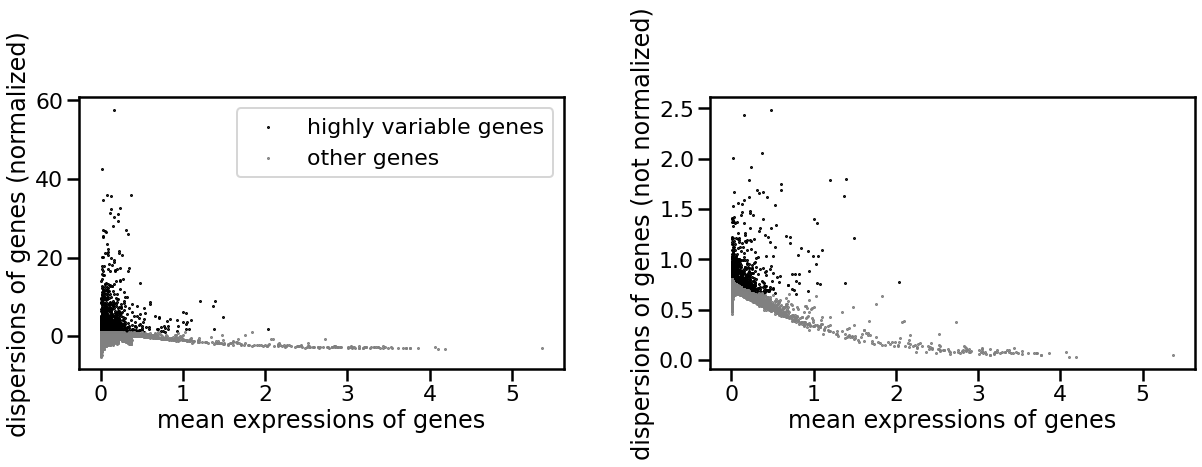

In [ ]:
rcParams['figure.figsize']=(10,5)
sc.pl.highly_variable_genes(adata)

The plots show how the data was normalized to select highly variable genes irrespective of the mean expression of the genes. This is achieved by using the index of dispersion which divides by mean expression, and subsequently binning the data by mean expression and selecting the most variable genes within each bin.

Highly variable gene information is stored automatically in the `adata.var['highly_variable']` field. The dataset now contains:

* count data as layer 'counts' in adata
* log-scran normalized data in adata.X
* highly variable gene annotations in `adata.var['highly_variable']`


## Visualization

Compute the following embeddings: PCA, t-SNE, UMAP, diffusion map and force-directed graph. Please compute PCA first and compute nearest neighbors next. All other embeddings rely on this information. Visualize the embeddings and color by the total number of counts.

In [ ]:
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')

    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:05)


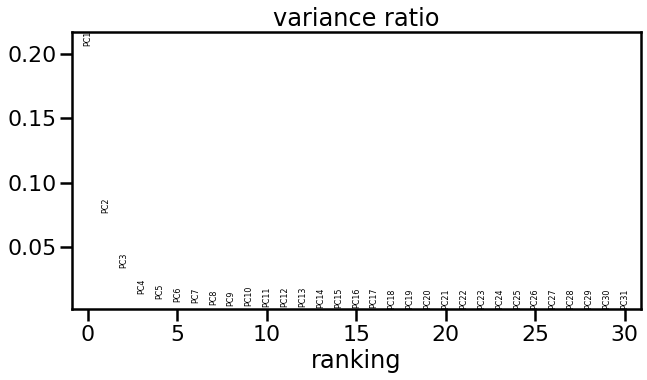

In [ ]:
sc.pl.pca_variance_ratio(adata)

Using the elbow method, we select the first 6 PCs as informative.

In [ ]:
sc.pp.pca(adata, n_comps=6, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)
sc.tl.tsne(adata) #Note n_jobs works for MulticoreTSNE, but not regular implementation)
sc.tl.umap(adata)
sc.tl.diffmap(adata)
sc.tl.draw_graph(adata)

    on highly variable genes
computing PCA with n_comps = 6
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 6
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)
computing tSNE
    using 'X_pca' with n_pcs = 6
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:35)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:12)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.99990594 0.99933165 0.99839467 0.9959535  0.99575377
     0.9951324  0.9936216  0.9856725  0.98217356 0.96494335 0.96389675
     0.9627942  0.95123124 0.94771546]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adat

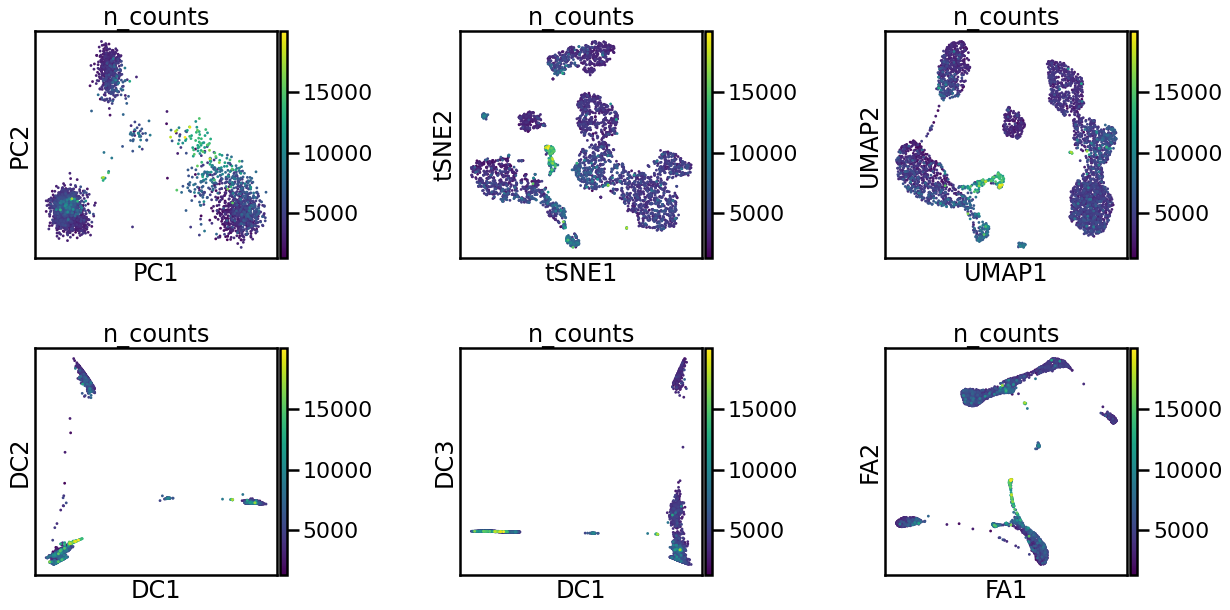

In [ ]:
rcParams['figure.figsize']=(20,10)
fig_ind=np.arange(231, 237)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p10 = sc.pl.pca_scatter(adata, color='n_counts', ax=fig.add_subplot(fig_ind[0]), show=False)
p11 = sc.pl.tsne(adata, color='n_counts', ax=fig.add_subplot(fig_ind[1]), show=False)
p12 = sc.pl.umap(adata, color='n_counts', ax=fig.add_subplot(fig_ind[2]), show=False)
p13 = sc.pl.diffmap(adata, color='n_counts', components=['1,2'], ax=fig.add_subplot(fig_ind[3]),show=False)
p14 = sc.pl.diffmap(adata, color='n_counts', components=['1,3'], ax=fig.add_subplot(fig_ind[4]), show=False)
p15 = sc.pl.draw_graph(adata, color='n_counts', ax=fig.add_subplot(fig_ind[5]), show=False)

plt.show()

**PCA**:

* Unsurprisingly, the first principle component captures variation in count depth between cells, and is thus only marginally informative
* The plot shows a weak clustering of the data in two dimensions

**t-SNE**:

* Shows several distinct clusters with clear subcluster structure
* Connections between clusters are difficult to interpret visually

**UMAP**:

* Data points are spread out on the plot showing several clusters
* Connections between clusters also not visible (and not expected for PBMC data)

**Diffusion Maps**:

* Shows regions of higher density and a few disconnected cells in between
* Trajectories not visible (and not expected for PBMC data)
* Each diffusion component extracts heterogeneity in a different part of the data

**Graph**:

* Shows several clusters with substructure
* Lack of trajectories as expected



## Cell cycle scoring

Known sources of technical variation in the data have been investigated and corrected for (e.g. batch, count depth). A known source of biological variation that can explain the data is the cell cycle. Here, gene lists from [Macosko et al., Cell 161 (2015)](https://www.sciencedirect.com/science/article/pii/S0092867415005498) is used to score the cell cycle effect in the data and classify cells by cell cycle phase. The file can be found on the [scIB github repository](https://github.com/theislab/scib/tree/master/scIB/resources/).

Please note, that the gene list was generated for human HeLa cells.

In [ ]:
s_genes_file = data_dir + 's_genes_tirosh_hm.txt'
g2m_genes_file = data_dir + 'g2m_genes_tirosh_hm.txt'

In [ ]:
s_genes = pd.read_table(s_genes_file, header = None).values.flatten()
g2m_genes = pd.read_table(g2m_genes_file, header = None).values.flatten()

In [ ]:
s_genes_hvg = adata.var_names[np.in1d(adata.var_names, s_genes)]
g2m_genes_hvg = adata.var_names[np.in1d(adata.var_names, g2m_genes)]

Compute cell cycle score per batch.

In [ ]:
adata.obs['S_score']= np.zeros(adata.shape[0])
adata.obs['G2M_score'] = np.zeros(adata.shape[0])
adata.obs['phase'] = np.zeros(adata.shape[0])

In [ ]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes_hvg, g2m_genes=g2m_genes_hvg)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs) (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs) (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


In [ ]:
print(len(s_genes_hvg))
print(len(g2m_genes_hvg))

27
26


In [ ]:
adata.obs['phase'].value_counts()

G1     1473
S      1257
G2M    1113
Name: phase, dtype: int64

Let us check whether MKI67 is present in the dataset.

In [ ]:
sum(adata.var_names == 'MKI67')

1

... storing 'phase' as categorical


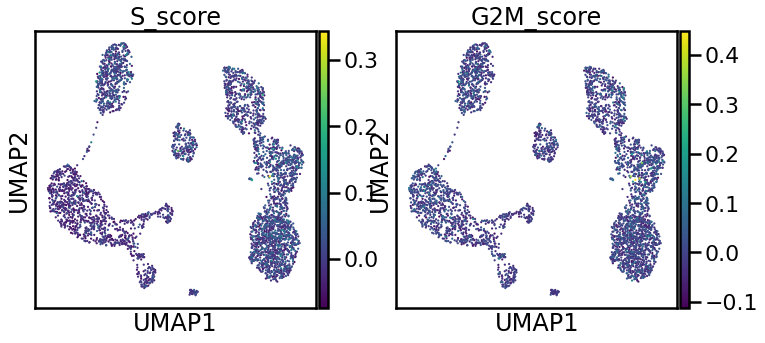

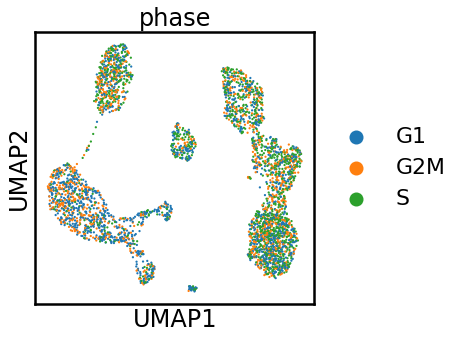

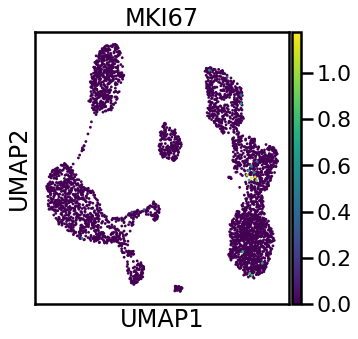

In [ ]:
rcParams['figure.figsize']=(5,5)
sc.pl.umap(adata, color=['S_score', 'G2M_score'], size=20, use_raw=False)
sc.pl.umap(adata, color=['phase'], size=20, use_raw=False)
#a classical interphase marker (which is not present in this dataset, unfortunately, is MKI67)
sc.pl.umap(adata, color='MKI67')

In [ ]:
import scipy.sparse as sparse

In [ ]:
adata.X = sparse.csr_matrix(adata.X)

In [ ]:
adata.write(data_dir + 'data_processed.h5ad')

# Downstream analysis

In [ ]:
adata = sc.read(data_dir + 'data_processed.h5ad')

## Clustering

Compute a `louvain` clustering with two different resolutions (`0.5` and `1`). Compare the clusterings in a table and visualize the clustering in an embedding. Optional: Compute a clustering with the `leiden` algorithm.

In [ ]:
# Perform clustering - using highly variable genes
sc.tl.louvain(adata, resolution=1.5, key_added='louvain_r1.5')
sc.tl.louvain(adata, resolution=0.5, key_added='louvain_r0.5')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 18 clusters and added
    'louvain_r1.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 9 clusters and added
    'louvain_r0.5', the cluster labels (adata.obs, categorical) (0:00:00)


In [ ]:
pd.crosstab(adata.obs['louvain_r0.5'], adata.obs['louvain_r1.5'])

louvain_r1.5,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
louvain_r0.5,,,,,,,,,,,,,,,,,,
0,416,397,0,0,0,0,213,0,0,0,0,0,0,0,0,0,0,17
1,0,0,0,0,283,254,0,212,0,0,0,0,0,0,0,0,0,0
2,0,0,368,0,0,0,0,0,56,0,0,54,0,0,103,0,0,0
3,0,0,0,354,0,0,0,0,0,0,174,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,133,0,0,116,152,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,137,0,99,0,0
6,0,0,0,0,0,0,0,0,0,180,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,88,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37


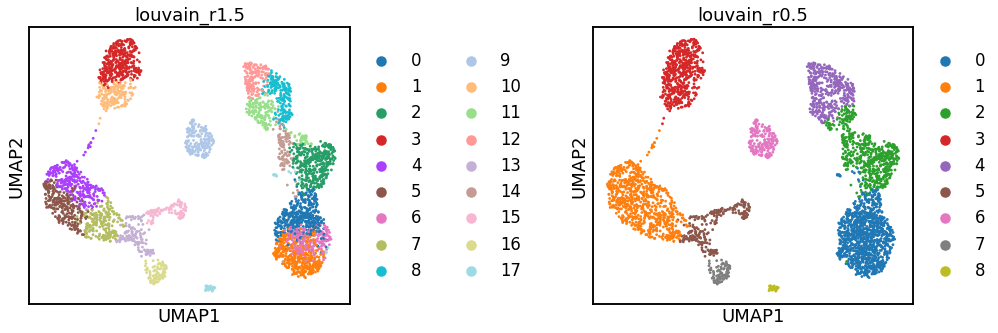

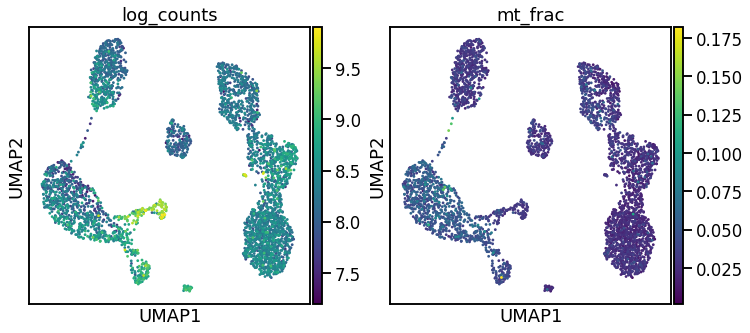

In [ ]:
#Visualize the clustering and how this is reflected by different technical covariates
sc.pl.umap(adata, color=['louvain_r1.5', 'louvain_r0.5'], wspace=0.6)
sc.pl.umap(adata, color=['log_counts', 'mt_frac'])

## Marker genes and cluster annotation

Compute the differential expression profile for each cluster with `rank_genes_groups` and visualize the results.

In [ ]:
#Calculate marker genes
sc.tl.rank_genes_groups(adata, groupby='louvain_r0.5', key_added='rank_genes_r0.5')

ranking genes
    finished: added to `.uns['rank_genes_r0.5']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


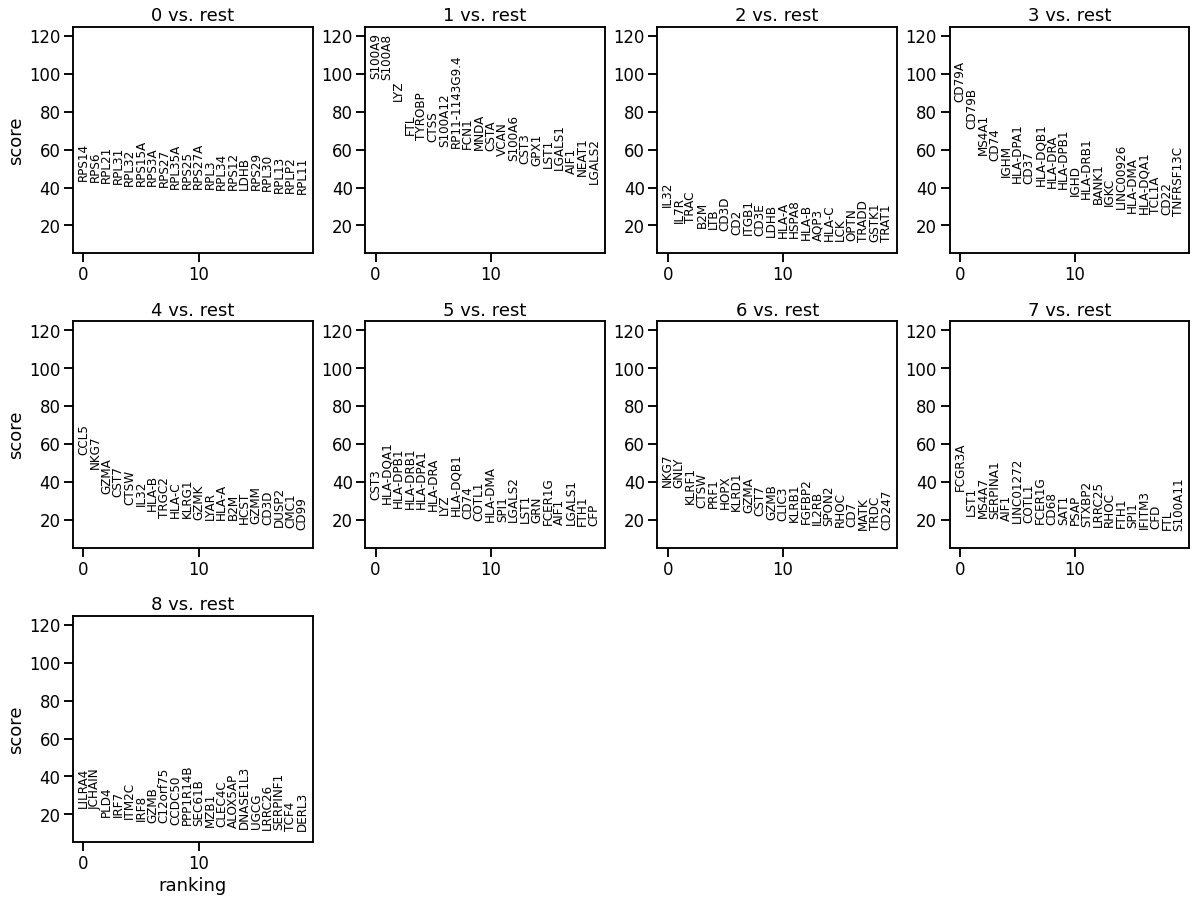

In [ ]:
#Plot marker genes
sc.pl.rank_genes_groups(adata, key='rank_genes_r0.5', fontsize=12)

In [ ]:
#Calculate marker genes
sc.tl.rank_genes_groups(adata, groupby='louvain_r1.5', key_added='rank_genes_r1.5')

ranking genes
    finished: added to `.uns['rank_genes_r1.5']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


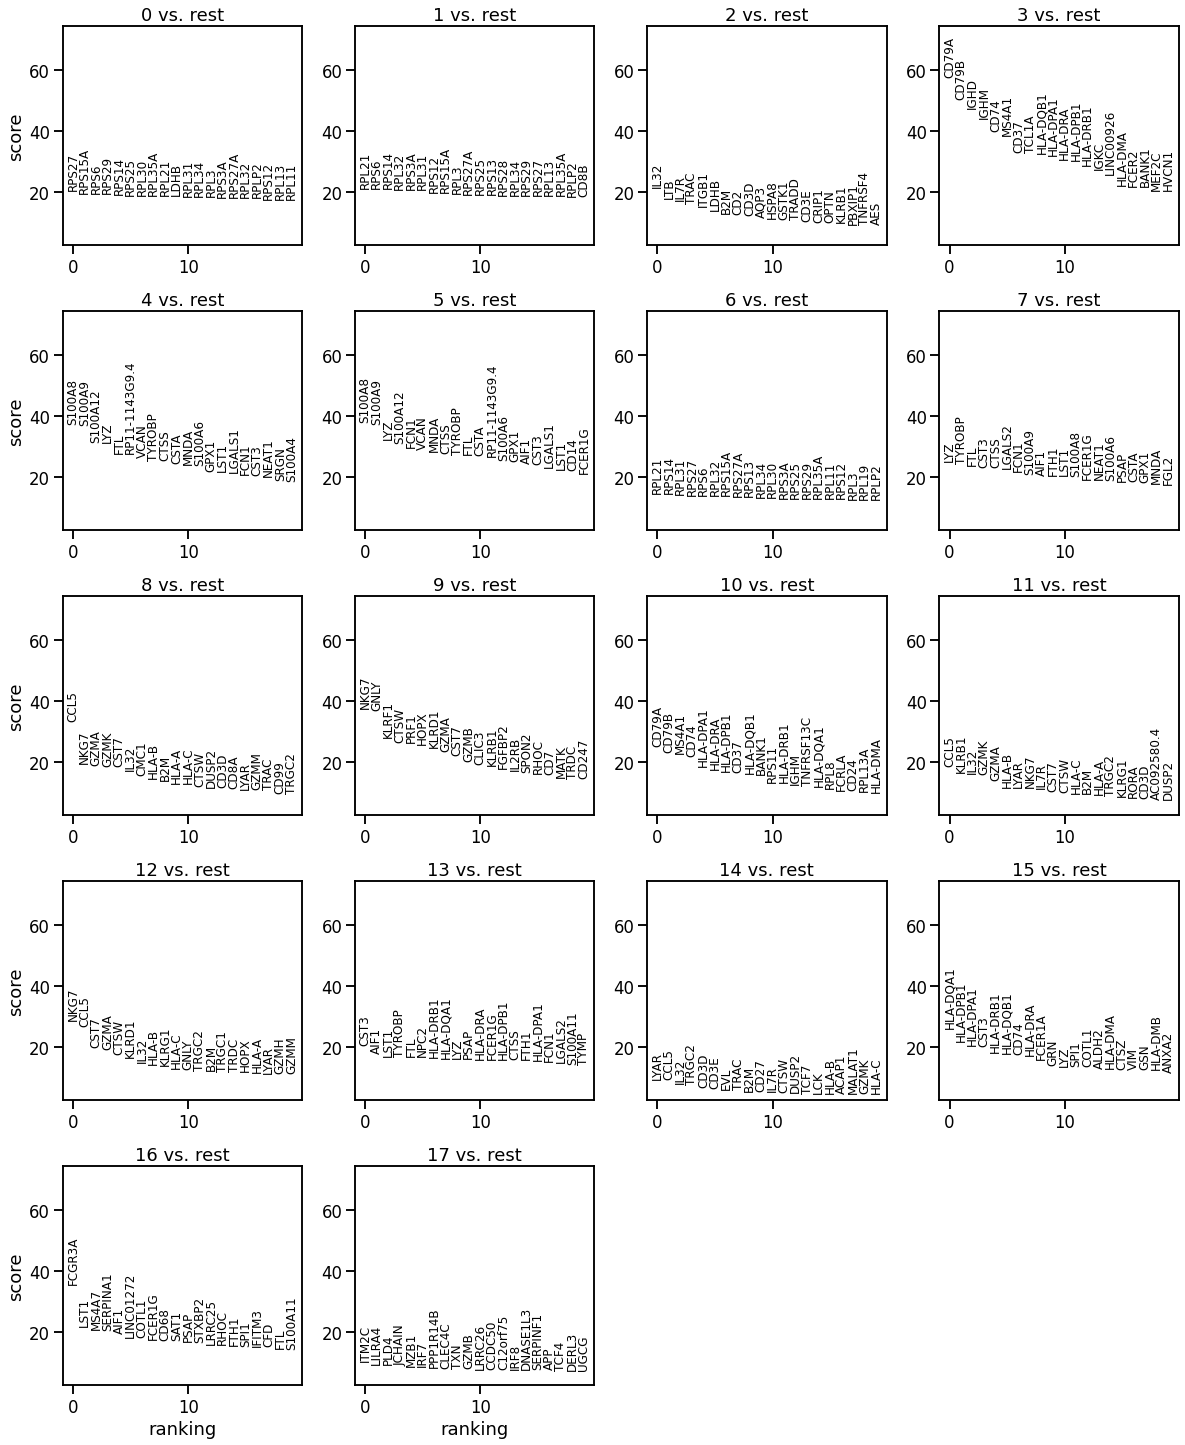

In [ ]:
#Plot marker genes
sc.pl.rank_genes_groups(adata, key='rank_genes_r1.5', fontsize=12)

Here, we observe a considerable ribosomal proteins (*RPL* and *RPS*), which are part of the ribosomes. Thus, they are involved in mRNA translational processes. Usually, these genes are difficult to interpret.

When it comes to cluster annotation, we have to tap into prior knowledge of the cell type from several studies and single-cell RNA-sequencing data analysis tutorials to extract marker gene sets.

The following list is extracted from the Seurat tutorial on PBMCs.


|Marker Gene|Cell Type|
|---------|-------|
|IL7R|CD4 T cells|
|CD14, LYZ|CD14+ Monocytes|
|MS4A1|B cells|
|CD8A|CD8 T cells|
|FCGR3A, MS4A7|FCGR3A+ Monocytes|
|GNLY, NKG7|NK cells|
|FCER1A, CST3|Dendritic Cells|
|PPBP|Megakaryocytes|


Let us define a list of marker genes from literature.

In [ ]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

Annotate the clusters. You can use auxilliary plots like `matrixplot`, `dotplot`,`heatmap` or `violin` plots or coloring an embedding by the marker genes.

Let us check if the marker genes are expressed in our dataset.

In [ ]:
np.in1d(marker_genes, adata.var_names)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

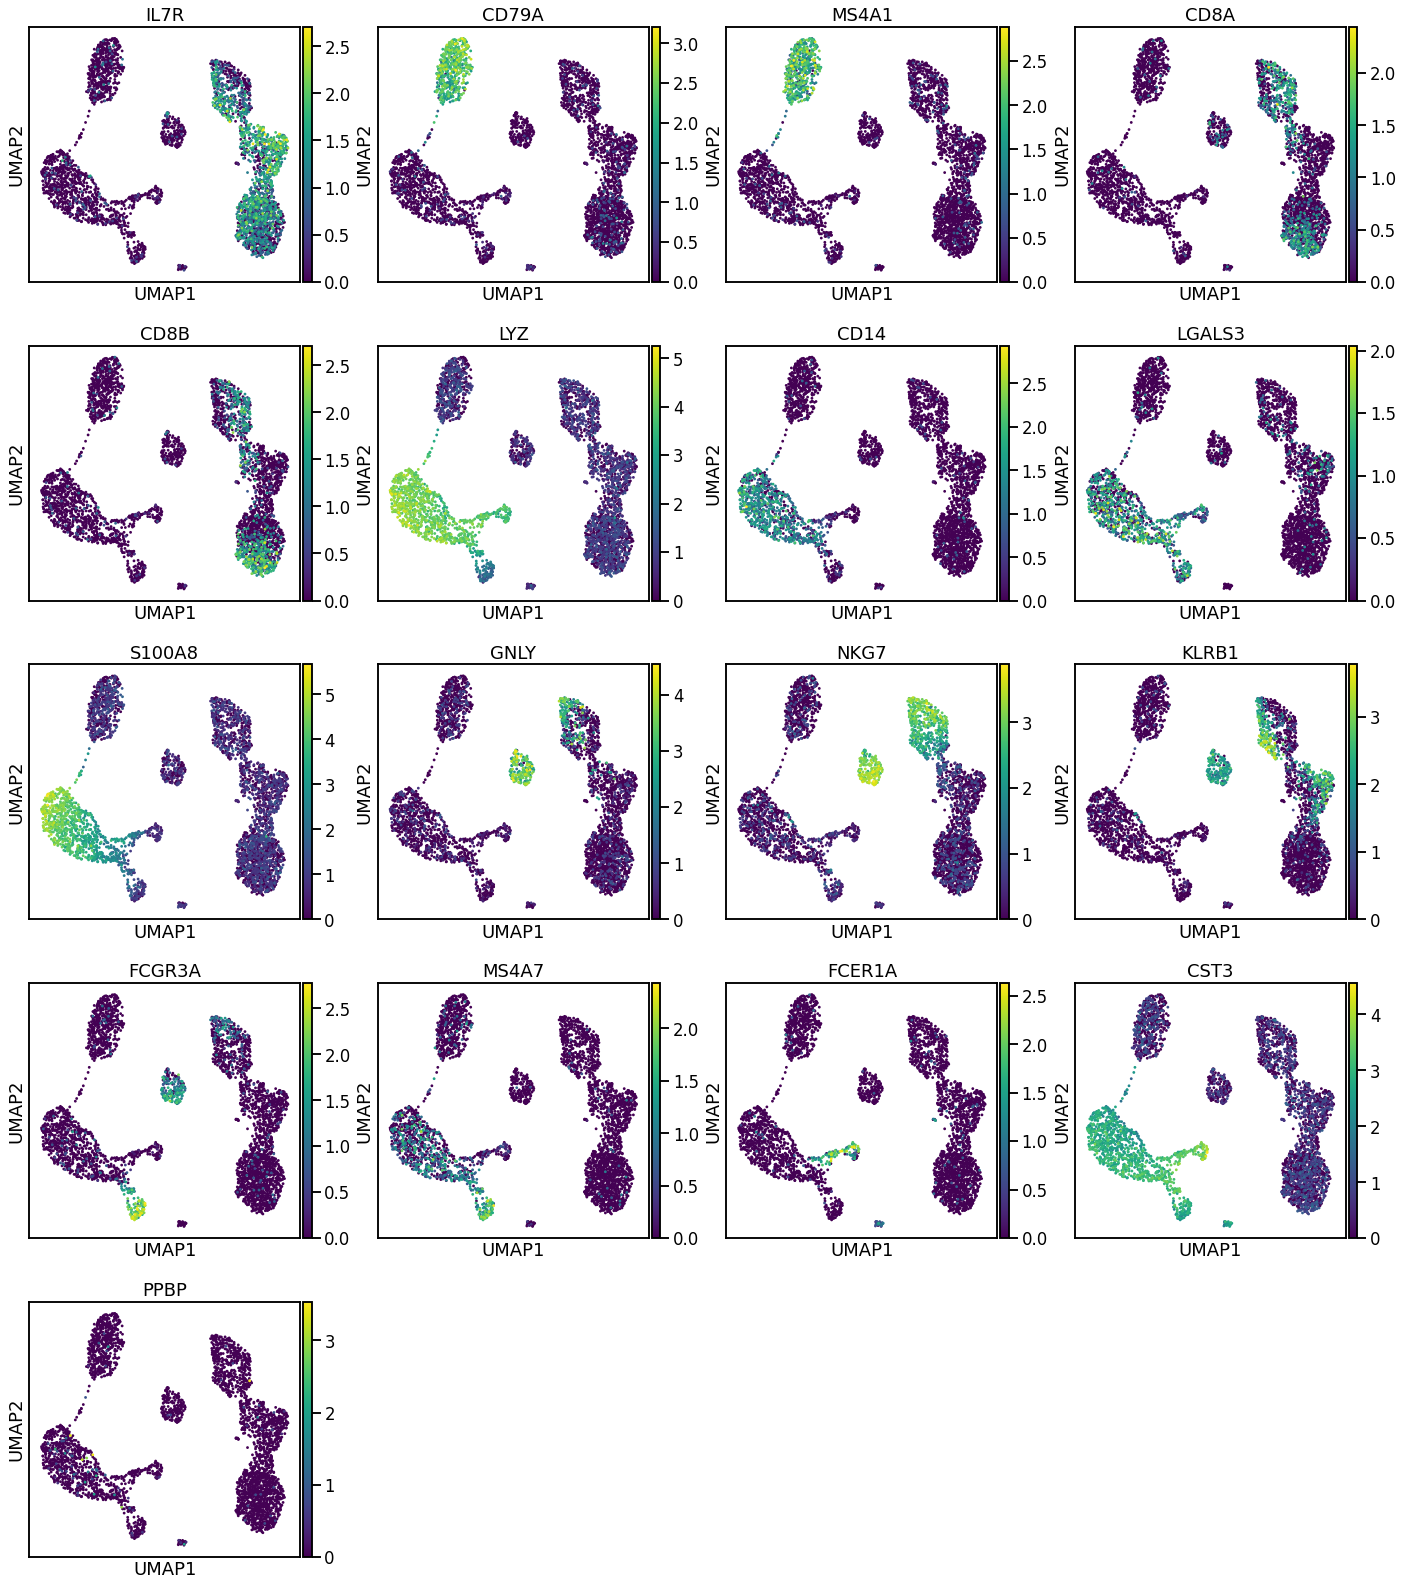

In [ ]:
sc.pl.umap(adata=adata, color=marker_genes, use_raw=False)

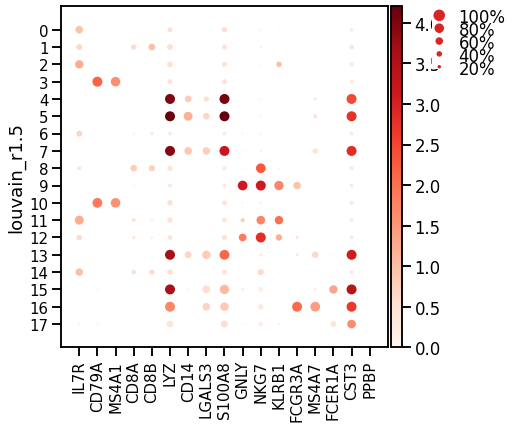

In [ ]:
ax = sc.pl.dotplot(adata, marker_genes, groupby='louvain_r1.5', use_raw=False)

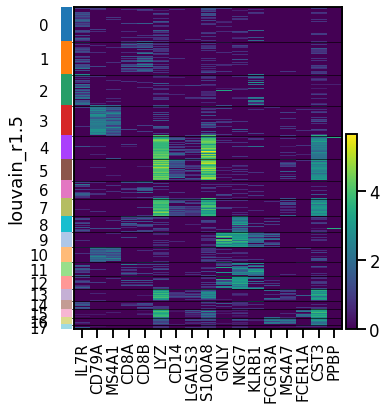

GridSpec(2, 4, height_ratios=[0, 6], width_ratios=[0.2, 5.1, 0, 0.2])

In [ ]:
sc.pl.heatmap(adata=adata, var_names=marker_genes,
              groupby='louvain_r1.5', use_raw=False, vmin=0)

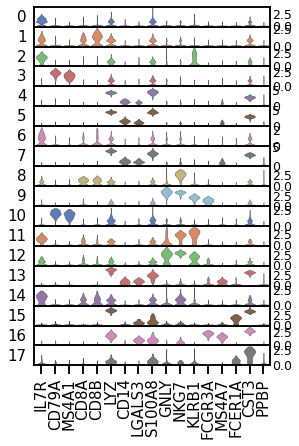

In [ ]:
ax = sc.pl.stacked_violin(adata, marker_genes, groupby='louvain_r1.5', use_raw=False)

Annotate clusters and create a new covariate.


|Cluster ID|Marker Gene|Cell Type|
|---------|-------|-------|
|0,2,6,11|IL7R|CD4 T cells|
|4,5,7,13|CD14, LYZ|CD14+ Monocytes|
|3,10|MS4A1|B cells|
|1,8,11,14|CD8A|CD8 T cells|
|16|FCGR3A, MS4A7|FCGR3A+ Monocytes|
|9,12|GNLY, NKG7|NK cells|
|15,17|FCER1A, CST3|Dendritic Cells|
|none|PPBP|Megakaryocytes|

Use the `pandas` data frame functionality to rename your clusters and visualize your annotation.

In [ ]:
adata.obs['annotated'] = adata.obs['louvain_r1.5'].cat.add_categories(['CD4 T cells',
                        'CD14+ Monocytes', 'B cells', 'CD8 T cells',
                        'FCGR3A+ Monocytes', 'NK cells', 'Dendritic cells'])

adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['0','2','6','11'])] = 'CD4 T cells'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['4','5','7','13'])] = 'CD14+ Monocytes'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['3','10'])] = 'B cells'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['1','8','11','14'])] = 'CD8 T cells'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['16'])] = 'FCGR3A+ Monocytes'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['9', '12'])] = 'NK cells'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['15','17'])] = 'Dendritic cells'

adata.obs['annotated'] = adata.obs['annotated'].cat.remove_unused_categories()

In [ ]:
adata.obs['annotated'].value_counts()

CD4 T cells          1167
CD14+ Monocytes       886
CD8 T cells           689
B cells               528
NK cells              332
Dendritic cells       153
FCGR3A+ Monocytes      88
Name: annotated, dtype: int64

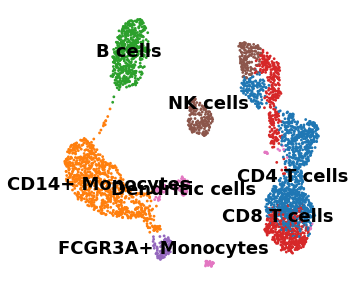

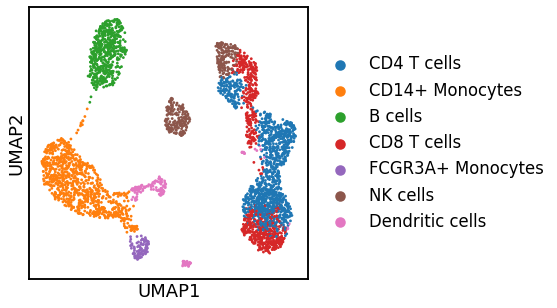

In [ ]:
sc.pl.umap(adata, color='annotated', legend_loc='on data', title='', frameon=False)
sc.pl.umap(adata, color='annotated',  title='', frameon=True)

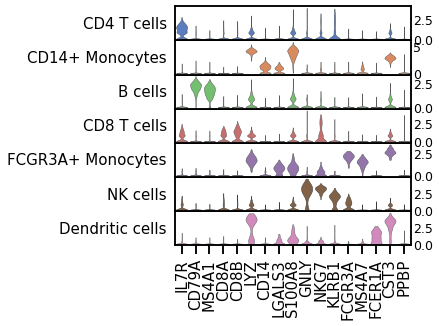

In [ ]:
ax = sc.pl.stacked_violin(adata, marker_genes, groupby='annotated', use_raw=False)

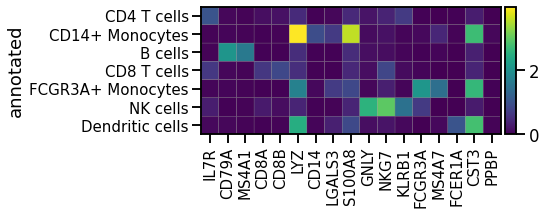

GridSpec(2, 3, height_ratios=[0, 10.5], width_ratios=[5.44, 0, 0.2])

In [ ]:
sc.pl.matrixplot(adata, marker_genes, groupby='annotated', use_raw=False, vmin=0)

### Inspect subpopulations of B cells

Let us determine the differences in the B cell clusters by differential expression. Subcluster the B cells first.

In [ ]:
sc.tl.louvain(adata, resolution=0.2, restrict_to = ['annotated',['B cells']], key_added='louvain_R')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 8 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)


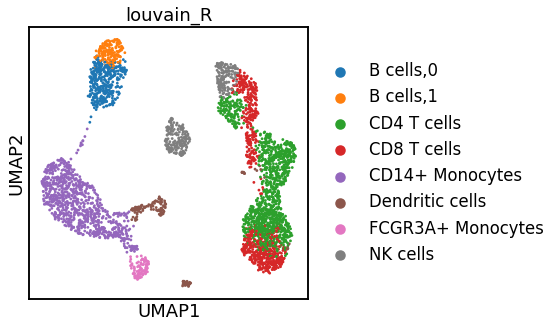

In [ ]:
rcParams['figure.figsize']= (5,5)
sc.pl.umap(adata, color='louvain_R')

In [ ]:
sc.tl.rank_genes_groups(adata = adata, groupby='louvain_R', groups= ['B cells,1'], reference='B cells,0', rankby_abs=True)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


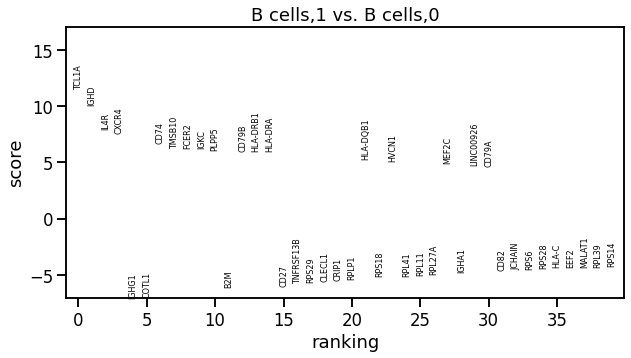

In [ ]:
rcParams['figure.figsize']=(10,5)
sc.pl.rank_genes_groups(adata, size=10, n_genes=40)

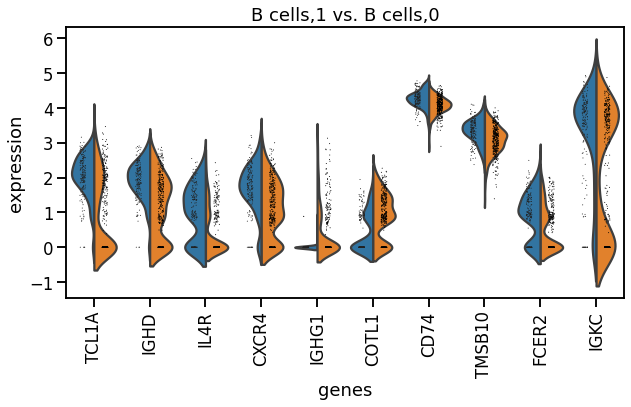

In [ ]:
sc.pl.rank_genes_groups_violin(adata, groups='B cells,1', n_genes=10, use_raw=False)

Here, the B cell populations differ in B cell activation markers such as TCL1A and IL4R. Interestingly, the `B cells,1` population is almost exclusively positive for the *IGKC* gene. The *IGKC* gene was found to be predictive for cancer prognosis.
Potentially, `B cells,1` are activated B cells and `B cells,0` are resting, but we have to look at more markers to make the distinction.

### Compute a PAGA for PBMCs

We aim to find relations between the respective cell types based on the knn graph with partition-based graph abstraction (PAGA).

Compute PAGA on the cluster annotation and plot the graph (note: use the plot function `paga_compare`).

In [ ]:
sc.tl.paga(adata = adata, groups='annotated')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


--> added 'pos', the PAGA positions (adata.uns['paga'])


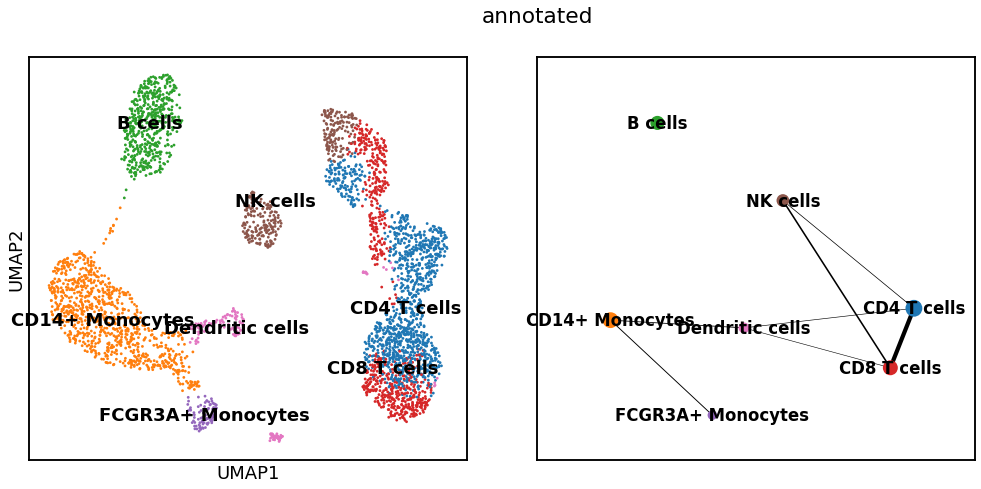

In [ ]:
rcParams['figure.figsize']=(7,7)
sc.pl.paga_compare(adata = adata, basis='umap', frameon=True)

## Save annotated data to file

In [ ]:
adata.write(data_dir + 'data_processed.h5ad')